In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

# Figure 2D

Aggregating fate prediction accuracy across methods

### Import packages

In [8]:
import ABCParse
import anndata
import cellplots as cp
import glob
import larry
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import scdiffeq as sdq
import scdiffeq_analyses as sdq_an
import sklearn

from typing import List, Optional

<IPython.core.display.Javascript object>

### Helper functions

In [55]:
def _read_process_F_hat(path, pickle=False, filter_nan=True):

    if pickle:
        F_hat = pd.read_pickle(path)[0]
    else:
        F_hat = pd.read_csv(path, index_col=0)
    F_hat_filt = F_hat.copy().drop("Undifferentiated", axis=1)
    F_hat_filt_norm = F_hat_filt.div(F_hat_filt.sum(1), axis=0).fillna(0)
    if filter_nan:
        F_hat_filt_norm = replace_undiff(F_hat_filt_norm)
    F_hat_filt_norm.index = F_obs.index  # F_hat_filt_norm.index.astype(str)
    return F_hat_filt_norm


def replace_undiff(F_hat_filt_norm):

    # create a temp vector to add undiff label
    undiff = np.zeros(len(F_hat_filt_norm))
    replace_idx = np.where(F_hat_filt_norm.sum(1) == 0)
    #     print(f"{replace_idx[0].shape[0]} non-fates")
    undiff[replace_idx] = 1

    # add to normalized matrix
    F_hat_filt_norm["Undifferentiated"] = undiff

    return F_hat_filt_norm


def compute_accuracy(F_obs, F_hat):
    y_true, y_pred = F_obs.idxmax(1).tolist(), F_hat.idxmax(1).tolist()
    return sklearn.metrics.accuracy_score(y_true, y_pred)


def get_organized_results(project_path):
    paths = list(project_path.glob("*/fate_prediction_metrics/*/F_hat.unfiltered.csv"))
    OrgResults = {}
    for path in paths:
        path_ = pathlib.Path(path)
        version = path_.parent.parent.parent.name
        if not version in OrgResults:
            OrgResults[version] = {}
        ckpt_name = path_.parent.name
        F_hat = _read_process_F_hat(path_, pickle=False)
        F_hat.index = F_hat.index.astype(str)
        acc = larry.tasks.fate_prediction.metrics.multi_idx_accuracy(F_obs, F_hat)
        train_acc = acc.loc["unique_train.all_fates"].iloc[0]
        test_acc = acc.loc["unique_test.all_fates"].iloc[0]
        OrgResults[version][ckpt_name] = {"train": train_acc, "test": test_acc}
        acc_ = compute_accuracy(F_obs, F_hat)
    #         print("| Accuracy: Train: {:.5f}, Test: {:.3f} |".format(train_acc, test_acc), version, ckpt_name)
    return OrgResults


def get_best_results(OrgResults):
    BestResults = {}
    for key, val in OrgResults.items():
        version_accuracy = pd.DataFrame(val).T
        best_ckpt = version_accuracy["train"].idxmax()
        best_test = version_accuracy.loc[best_ckpt]["test"]
        #         print(key, best_ckpt, best_test)
        #         best_.append()
        BestResults[key] = best_test

    return BestResults

<IPython.core.display.Javascript object>

### Load `adata`

In [72]:
adata = anndata.read_h5ad("/home/mvinyard/data/adata.LARRY_train.19MARCH2024.h5ad")

<IPython.core.display.Javascript object>

### F_obs (`pd.DataFrame`)

In [62]:
F_obs = larry.tasks.fate_prediction.F_obs

<IPython.core.display.Javascript object>

### Linear regression (LR)

In [11]:
LR = [
    0.600698,
    0.591385,
    0.601863,
    0.600698,
    0.606519,
]

<IPython.core.display.Javascript object>

### CellRank

In [78]:
F_hat_cellrank = pd.read_pickle(
    "/home/mvinyard/github/scdiffeq-analyses/analyses/figure2/LARRY.fate_prediction/CellRank/ruitong_cellrank_dynamo/Seed0_termFate2.pickle"
)

adata.obs["combined_barcode"] = (
    adata.obs["Library"].astype(str)
    + ":"
    + adata.obs["Cell barcode"].str.replace("-", "")
)
F_hat_cellrank_index = adata.obs.loc[
    adata.obs["combined_barcode"].isin(F_hat_cellrank.index)
].index
F_hat_cellrank.index = F_hat_cellrank_index
F_hat_cellrank = F_hat_cellrank.div(F_hat_cellrank.sum(1), axis=0).fillna(0)
F_hat_cellrank = replace_undiff(F_hat_cellrank)
cellrank = compute_accuracy(F_obs, F_hat=F_hat_cellrank)

<IPython.core.display.Javascript object>

### Dynamo

In [73]:
dynamo_csv_path = "/home/mvinyard/github/scdiffeq-analyses/analyses/figure2/LARRY.fate_prediction/dynamo/dynamo_fatebias.seed_0.csv"
adata.obs["combined_barcode"] = (
    adata.obs["Library"].astype(str)
    + ":"
    + adata.obs["Cell barcode"].str.replace("-", "")
)
F_hat_dynamo = pd.read_csv(dynamo_csv_path, index_col=0)
F_hat_dynamo_index = adata.obs.loc[
    adata.obs["combined_barcode"].isin(F_hat_dynamo.index)
].index
F_hat_dynamo.index = F_hat_dynamo_index
F_hat_dynamo = F_hat_dynamo.drop("confidence", axis=1)
F_hat_dynamo = F_hat_dynamo.drop("Undifferentiated", axis=1)
F_hat_dynamo = F_hat_dynamo.div(F_hat_dynamo.sum(1), axis=0).fillna(0)
F_hat_dynamo = replace_undiff(F_hat_dynamo)
dynamo = compute_accuracy(F_obs, F_hat=F_hat_dynamo)

<IPython.core.display.Javascript object>

### PRESCIENT

In [67]:
F_hat_prescient = pd.read_csv(
    "/home/mvinyard/experiments/run_prescient/F_hat.csvs/F_hat.PRESCIENT.LARRY.all_data.all_kegg-softplus_2_400-1e-06.seed_1.train.best.pt.csv",
    index_col=0,
)
kegg_indicator = {"yes": "KEGG+", "no": "KEGG-"}

PRESCIENT_results = {"KEGG+": [], "KEGG-": []}
paths = list(pathlib.Path("/home/mvinyard/data/").glob("prescient*.pickle"))
for path in paths:
    F_hat_pr = _read_process_F_hat(path=path, pickle=True)
    acc = larry.tasks.fate_prediction.metrics.multi_idx_accuracy(F_obs, F_hat=F_hat_pr)
    test_acc = acc.loc["unique_test.all_fates"].iloc[0]
    #     print(test_acc)
    kegg_key = kegg_indicator[path.name.split("KEGG")[-1].split(".pickle")[0]]
    PRESCIENT_results[kegg_key].append(test_acc)
PRESCIENT = pd.DataFrame(PRESCIENT_results)

<IPython.core.display.Javascript object>

### scDiffEq

In [56]:
# scDiffEq - KEGG (no RVR)
f = pd.read_pickle(
    "/home/mvinyard/github/scdiffeq-analyses/analyses/figure2/LARRY.fate_prediction/scDiffEq/scdiffeq_simout.pickle"
)

scDiffEq_KEGGNeg = {}
for seed in range(5):
    key = ("scDiffEq1", "mu2000-sigma800-ss1", f"seed{seed}", "KEGGno")
    F_hat_raw = f[key]
    F_hat_raw.index = F_obs.index
    F_hat_filt = F_hat_raw.drop("Undifferentiated", axis=1)
    F_hat_norm = F_hat_filt.div(F_hat_raw.sum(1), axis=0).fillna(0)
    F_hat_sdq = replace_undiff(F_hat_norm)
    acc = larry.tasks.fate_prediction.metrics.multi_idx_accuracy(F_obs, F_hat=F_hat_sdq)
    scDiffEq_KEGGNeg[seed] = acc.loc["unique_test.all_fates"].iloc[0]

# scDiffEq + KEGG (no RVR)
sdq_kegg = [
    0.6239813736903376,
    0.4947613504074505,
    0.5273573923166472,
    0.4947613504074505,
    0.5064027939464494,
]

# scDiffEq + KEGG + RVR=2.5
project_path = pathlib.Path(
    "/home/mvinyard/experiments/fate_prediction.reg_velo/v2/LightningSDE-FixedPotential-RegularizedVelocityRatio"
)
project = sdq.io.Project(project_path)
versions = [
    getattr(project, attr) for attr in project.__dir__() if attr.startswith("version_")
]

best = {}
for version in versions:
    version_accuracy = sdq_an.parsers.VersionAccuracy(version)
    Vr = version.hparams["velocity_ratio_params"]["target"]
    if Vr == 2.5:
        best[version._NAME] = version_accuracy.best_test_from_train[["train", "test"]]

sdq_Vr2pt5 = pd.DataFrame(best).T["test"].values
org_results = get_organized_results(project_path)
best_results = get_best_results(org_results)

scDiffEq = {
    "-KEGG": list(scDiffEq_KEGGNeg.values()),
    "+KEGG": sdq_kegg,
    "+KEGG+RVR2pt5": list(sdq_Vr2pt5),
}

<IPython.core.display.Javascript object>

### torch-PBA

In [23]:
TorchPBA = {}
for path in glob.glob(
    "/home/mvinyard/github/scdiffeq-analyses/analyses/figure2/LARRY.fate_prediction/PBA/PBA.F_hat_unfilt*.csv"
):
    path_ = pathlib.Path(path)
    seed = int(path_.name.split("seed_")[-1].split(".")[0])
    F_hat = pd.read_csv(path_, index_col=0)
    F_hat.index = F_hat.index.astype(str)
    acc = larry.tasks.fate_prediction.metrics.multi_idx_accuracy(F_obs, F_hat=F_hat)
    score = acc.loc["unique_test.all_fates"].iloc[0]
    TorchPBA[seed] = score

<IPython.core.display.Javascript object>

### Aggregate results

In [79]:
TorchPBA

{5: 0.42607683352735737,
 6: 0.5669383003492433,
 0: 0.40279394644935973,
 4: 0.3958090803259604,
 3: 0.519208381839348,
 1: 0.559953434225844}

<IPython.core.display.Javascript object>

[0.5087310826542492,
 0.5389988358556461,
 0.5389988358556461,
 0.5133876600698487,
 0.5261932479627474]

<IPython.core.display.Javascript object>

In [115]:
results = {
    "LR": LR,
    "PBA": [0.363213],
    "torch-pba": list(TorchPBA.values()),
    "TIGON": [0.04084574723690534],
    "CellRank": [cellrank],
    "Dynamo": [dynamo],
    "PRESCIENT": PRESCIENT_results["KEGG-"],
    "PRESCIENT-KEGG": PRESCIENT_results["KEGG+"],
    "scDiffEq": scDiffEq["-KEGG"],
    "scDiffEq-KEGG": scDiffEq["+KEGG"],
    "scDiffEq-KEGG-RV": scDiffEq["+KEGG+RVR2pt5"],
}

<IPython.core.display.Javascript object>

### Plot

In [116]:
class StylishBoxPlot(ABCParse.ABCParse):
    def __init__(
        self,
        colors: Optional[List[str]] = None,
        widths: Optional[float] = None,
        scatter_kw={
            "alpha": 0.8,
            "s": 25,
        },
        *args,
        **kwargs
    ):
        self.__parse__(locals())

    @property
    def colors(self):
        if not hasattr(self, "_colors") or self._colors is None:
            self._colors = list(cm.tab20.colors)
        return self._colors

    def _background_scatter(self, ax, data):
        for en, (key, val) in enumerate(data.items()):

            x = [key] * len(val)

            if len(x) > 1:
                x_vals = en + 1 + (np.random.random(len(x)) - 0.5) / 5
            else:
                x_vals = en + 1

            ax.scatter(
                x_vals,
                val,
                color=self.colors[en],
                zorder=0,
                ec="None",
                rasterized=False,
                **self._scatter_kw,
            )

    def _background_boxplot(self, ax, data):

        x = list(data.keys())
        y = list(data.values())

        x = np.arange(len(y)) + 1

        bp = ax.boxplot(
            y,
            positions=x,
            patch_artist=True,
            showmeans=True,
            showfliers=False,
            meanline=True,
            zorder=1,
            widths=self._widths,
        )
        for median in bp["medians"]:
            median.set_visible(False)
        for en, mean in enumerate(bp["means"]):
            mean.set_c(self.colors[en])

        for en, box in enumerate(bp["boxes"]):
            box.set_facecolor(self.colors[en])
            box.set_alpha(0.2)

        for en, whisker in enumerate(bp["whiskers"]):
            whisker.set_c("None")

        for en, cap in enumerate(bp["caps"]):
            cap.set_c("None")

    def _foreground_boxplot(self, ax, data):

        y = list(data.values())
        x = list(data.keys())
        x = np.arange(len(y)) + 1
        bp = ax.boxplot(
            y,
            positions=x,
            patch_artist=True,
            showmeans=False,
            showfliers=False,
            meanline=False,
            zorder=2,
            widths=self._widths,
        )
        for en, box in enumerate(bp["boxes"]):
            box.set_facecolor("None")
            box.set_edgecolor(self.colors[en])

        colors_ = np.repeat(
            np.array(self.colors), 2, axis=0
        )  # list(np.repeat(self.colors, 2))
        for en, whisker in enumerate(bp["whiskers"]):
            whisker.set_c(colors_[en])

        for en, cap in enumerate(bp["caps"]):
            cap.set_c(colors_[en])

        for median in bp["medians"]:
            median.set_visible(False)

    def __call__(self, ax, data, *args, **kwargs):

        self.__update__(locals())

        try:
            self._background_scatter(ax, data)
        except:
            print(data)
        self._background_boxplot(ax, data)
        self._foreground_boxplot(ax, data)

<IPython.core.display.Javascript object>

In [117]:
colors = [
    "#262626",
    "#f9626c",
    "#9d0610",
    "#ffcc00",
    "#99cc33",
    "#669900",
    "#f27f34",
    "#eb5e28",
    "#00b4d8",
    "#0096c7",
    "#0077b6",
]

<IPython.core.display.Javascript object>

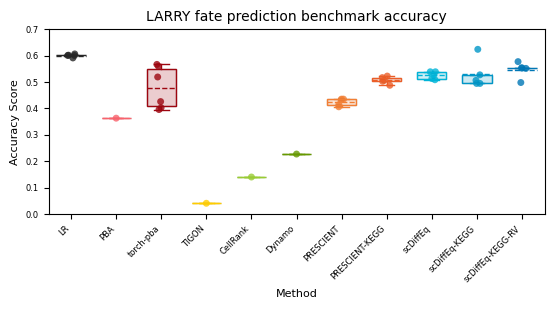

<IPython.core.display.Javascript object>

In [118]:
results = {key: ABCParse.as_list(val) for key, val in results.items()}

fig, axes = cp.plot(
    height=0.5,
    width=1,
    title=["LARRY fate prediction benchmark accuracy"],
    y_label=["Accuracy Score"],
    x_label=["Method"],
)
ax = axes[0]

sbp = StylishBoxPlot(colors=colors, widths=0.65)
sbp(ax, results)
ax.set_ylim(0, 0.7)
ax.set_xticks(np.arange(1, 12))
xtl = ax.set_xticklabels(list(results.keys()), ha="right", rotation=45)
plt.savefig("LARRY.fate_prediction_benchmark_accuracy.svg", dpi=500)